In [1]:

#Import modules
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, brier_score_loss

## Data generation, import and missing values

We first generate features and target variables for prediction by running the data generation script.
We use aggregations of transactions for the latest 3000 days (full history excluding the latest 60 days), and the latest 60 days prior to the loan date. These time horizons can be passed to the script as arguments and adjusted as you like.

In [2]:
#Windows powershell script to download and unzip data
#!data_download.bat

#Python script for data prep
!ipython credit_risk_datagen.py 3000 60

#open the pickled dataset generated by the script
with open('loan_data', 'rb') as file:
    loans = pickle.load(file, encoding="latin1")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\shellapp.py:340: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  raise_exceptions=True)
credit_risk_datagen.py:182: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trans_agg = trans_agg[(data.date_loan - data.date).dt.days > time_window_min]


In [3]:
#Missing observations
print('Missing observations')
print(loans.isna().sum()[loans.isna().sum() > 0])
print('\nTotal loans: ', len(loans))
print('Total cases with missing data: ', loans.isna().sum(axis=1).sum())
print(round(100*loans.isna().sum(axis=1).sum()/len(loans), 2),'% of total cases.')
print('Loans behind in payment with missing data: ', (loans[loans.isna().sum(axis=1).astype(bool)].target == 1).sum())
print('Total number of loans behind in payment: ', loans.target.sum())
print('Account age of loan with missing rate_max: ', loans[loans.rate_max.isna()].accnt_age.values[0])
print('Minimum age of loans: ', min(loans.accnt_age))
loans['rate_max'] = loans.rate_max.fillna(loans.rate_max_short)
loans['rate_min'] = loans.rate_min.fillna(loans.rate_max_short)
loans['rate_mean'] = loans.rate_mean.fillna(loans.rate_max_short)

Missing observations
applicants    8
rate_min      1
rate_mean     1
rate_max      1
dtype: int64

Total loans:  682
Total cases with missing data:  11
1.61 % of total cases.
Loans behind in payment with missing data:  3
Total number of loans behind in payment:  76.0
Account age of loan with missing rate_max:  0.2792607802874743
Minimum age of loans:  0.2792607802874743


The missing applicant data is from the earliest part of the data, which we can assume can be safely ignored. Additionally one observation for historical (longer term) rates is missing. The account associated has not been granted interest payments 60 days prior to loan issuance. We will replace the NA with the 2 month value.

We generate the final feature matrix X and target vector y.

In [4]:
X = loans[~loans.isna().sum(axis=1).astype(bool)]
y = X.target
X.drop(['target'], axis=1, inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Baseline linear model

We will begin with a baseline logistic regression models with the kitchen sink approach, using all generated features for prediction. As we have a large amount of features, we use the L2 (Ridge) regularization.

In addition I standardize the features. Standardizing helps the regression algorithm to converge and makes for easier interpretation of the coefficients as all are at the same scale.

Because there are relatively few loans that default, accuracy is not an ideal metric of model performance. Furthermore, because predictions are of interest in evaluating credit risk and setting loan rates, the predicted probability has a meaningful interpretation. I complement the prediction accuracy with the brier score which measures the mean squared difference between the predicted probability assigned to the problems in loan repayment and the actual outcome. The lower the brier score loss is, the better.

Because there is a time-series element to the data, ideally we would want to use a time-series split for cross-validation to make sure ex-post information does not affect model performance. However, because we have little data and the time-seriesness of the data is not likely to be a major concern, we will settle with 10-fold cross-validation.

We also generate the accuracy for the naive prediction that all loans complete succesfully. For the brier score loss we generate the benchmark loss for the naive prediction that the probability of a default is the same (sample mean) across all observations.

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class CustomScaler(BaseEstimator,TransformerMixin): 
    """
    Custom wrapper for the StandardScaler that does not scale
    dummy variables. This makes for more interpretable coefficients.
    
    """
    def __init__(self,columns):
        self.scaler = StandardScaler()
        self.columns = columns

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        if len(self.columns)>0:
            self.scaler.fit(X.iloc[:,self.columns], y)
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        mask = [i for i in range(len(X.columns)) if i not in self.columns]
        X_dummy = X.iloc[:,mask]
        if len(self.columns)>0:
            X_cont = pd.DataFrame(self.scaler.transform(X.iloc[:,self.columns]),
                                  columns=self.columns, index=X.index)
            frame = pd.concat([X_dummy, X_cont], axis=1)
        else:
            frame = X
        return frame

def create_pipeline(classifier, dummy):
    """ Create a pipeline with the custom scaler """
    pipe = Pipeline([
            ('scale', CustomScaler(dummy)),
            ('clf', classifier)])

    return pipe

#mask for the dummy variables
dummy_mask = [i for i, x in enumerate((X.max() != 1)|(X.min() != 0)) if x]

#crossvalidation object and scorer to be used for model fitting
kfold = StratifiedKFold(n_splits=10)
scorer = make_scorer(brier_score_loss, needs_proba=True)

#benchmark naive predictions
benchmark_acc = 1-np.mean(y)
benchmark_brier = brier_score_loss(y, np.repeat(np.mean(y), len(y)))

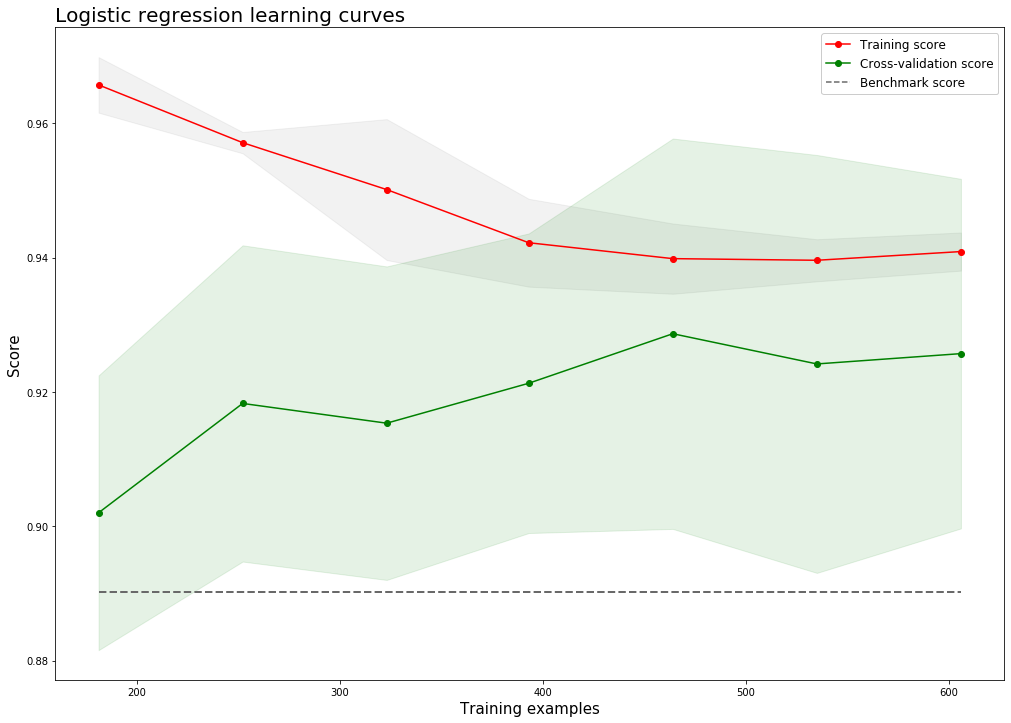

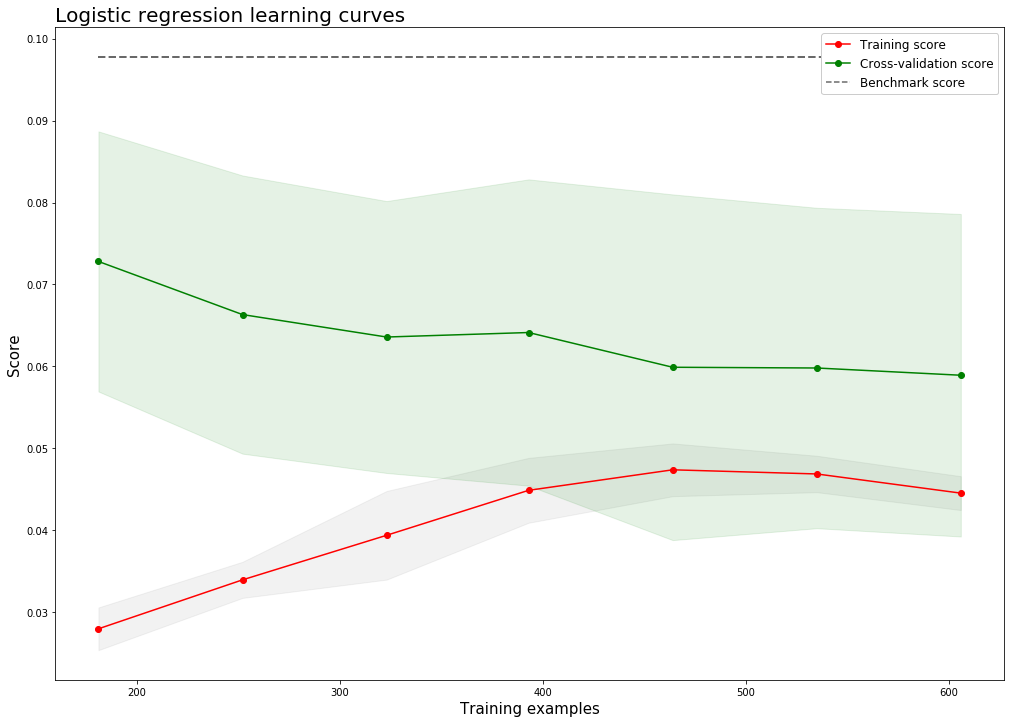

In [153]:
#Train initial baseline model

logr_params = {'C':1.15, 'class_weight':None, 'penalty': 'l1'}
logc = create_pipeline(LogisticRegression(**logr_params, solver='liblinear'), dummy_mask)

g = plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_acc)
g = plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_brier,
                       scoring = scorer)

## Feature selection with logistic regression

I try to find a simpler baseline model and improve cross-validation performance. For this I use sklearn's pre-built recursive feature selection by cross-validation. Recursive feature elimination removes the least important features recursively by fitting and refitting the linear classification model with less and less features.
This serves well as feature selection for the gradient boosting model as well.

In [154]:
class PipelineRFE(Pipeline):
        """
        Wrapper class for pipeline. Captures the coefficients from
        the pipeline, needed for recursive feature selection and recreates
        the list of columns used by the custom dummy-skipping StandardScaler
        """
        def fit(self, X, y=None, **fit_params):
            self.steps[0][1].columns = \
                [i for i, x in enumerate((np.amin(X, axis=0)!=0)|(np.amax(X, axis=0)!=1)) if x]
            super(PipelineRFE, self).fit(X, y, **fit_params)
            clf = self.steps[-1][-1]
            if hasattr(clf, 'coef_'):
                self.coef_ = clf.coef_
            else:
                self.feature_importances_ = clf.feature_importances_
            return self

def create_rfe_pipeline(classifier, dummies=None):
    """
    Function to automatically generate a pipeline to fit with standard scaler
    """
    pipe =  [
        ('std_scaler', CustomScaler(dummies)),
        ('clf', classifier)
    ]  
    return(PipelineRFE(pipe))

#create pipeline object and fit rfecv on it
logc_features = create_rfe_pipeline(LogisticRegression(**logr_params, solver='liblinear'), dummy_mask)
rfecv = RFECV(estimator=logc_features, step=1, cv=kfold,
              scoring='neg_log_loss')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=PipelineRFE(memory=None,
                            steps=[('std_scaler',
                                    CustomScaler(columns=[0, 1, 2, 3, 4, 5, 6,
                                                          7, 8, 9, 10, 11, 12,
                                                          13, 16, 17, 21, 22,
                                                          23, 24, 25, 26, 27,
                                                          29, 30, 31, 32, 33,
                                                          34, 35, ...])),
                                   ('clf',
                                    LogisticRegression(C=1.15,
                                                       class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                

Finally, I run a quick gridsearch cross-validation to sort out suitable parameters for the penalty used, strength of the regularization penalty and whether to use weighted classes.

In [156]:
#get mask to select only the features selected by feature elimination
mask = rfecv.support_
dummy_mask_rfe = [i for i, x in \
              enumerate((X.loc[:,mask].max() != 1)|(X.loc[:,mask].min() != 0)) if x]

In [157]:
#space of parameters to search from
search_params = {
        'clf__C':np.linspace(0.1, 3, 20),
        'clf__penalty':['l1', 'l2'],
        'clf__class_weight':[None, 'balanced'],
                }

#initiate and fit the grid search
search = GridSearchCV(create_pipeline(LogisticRegression(solver='liblinear', max_iter=100),
                                          dummy_mask_rfe),
                      search_params, cv=kfold, scoring='neg_log_loss')
search.fit(X.loc[:,mask], y)

#store final params and initiate a new pipeline
logr_tuned_params = dict(zip(['C','class_weight','penalty'],search.best_params_.values()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In case you dont want to run the gridserach, tuned params are assigned here

In [164]:
logr_tuned_params = {'C':0.86, 'class_weight':None, 'penalty': 'l1'}

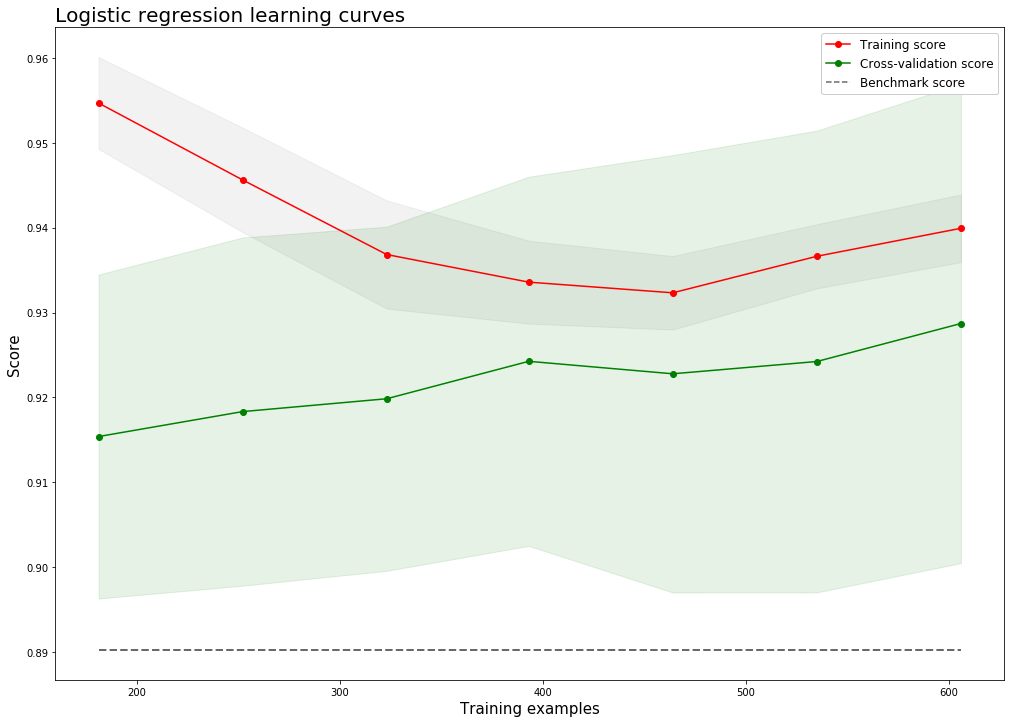

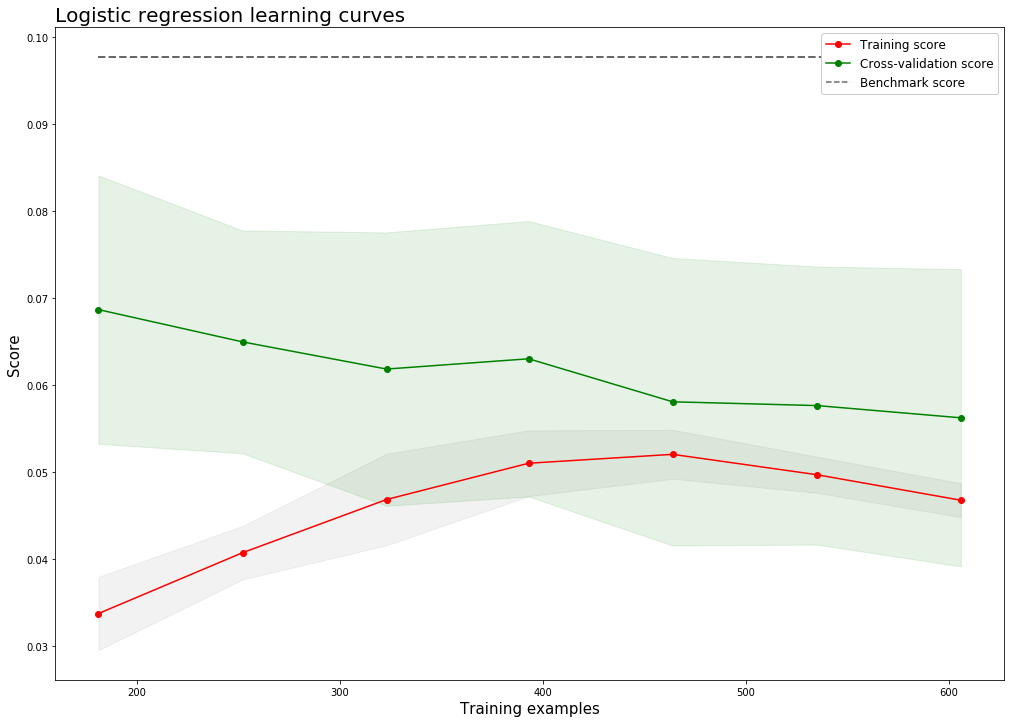

In [179]:
final_logc = create_rfe_pipeline(LogisticRegression(**logr_tuned_params, solver='liblinear'))

#Finally fit and find the learning curve
g, bm_lin_acc = plot_learning_curve(final_logc,"Logistic regression learning curves",X.loc[:,mask], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_acc)
g, bm_lin_brier = plot_learning_curve(final_logc,"Logistic regression learning curves",X.loc[:,mask], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_brier,
                       scoring = scorer)

### Model coefficients

In [263]:
#refit the final model
final_logc.fit(X.loc[:,mask], y)

#get the non-zero coefficients and respective column names
cols = X.loc[:,mask].columns[final_logc.coef_[0] != 0]
coefs = final_logc.coef_[0][final_logc.coef_[0]!=0]

print("The final linear model has {} predictor variables".format(len(coefs)))
pd.DataFrame(dict(zip((cols), (coefs))), index=['Coef']).T

The final linear model has 25 predictor variables


,Coef
amount,-2.178228
duration,2.873469
payments,2.308292
A4,0.645186
A5,0.201788
A6,-0.013026
A7,0.425328
A13,-0.249642
accnt_age,-0.424169
rate,-0.365853


We end up with a 25-feature logistic regression model that seems to perform slightly better than the kitchen sink regression model. This model provides a good benchmark for the gradient boosting.

There are a lot of coefficients and the predictor variables are highly correlated at times. Because of this there is a lot of interplay between the coefficients and interpreting individual coefficients is likely not too meaningful. Note that this multicollinearity should not affect model performance, especially as the training is validated using hold-out data.


## Gradient Boosting Model

We train the gradient boosting model with the set of features selected by the linear model feature selection process.

It turns out that the linear model performs very well on this small dataset and is very difficult to beat. With careful hyperparameter search, we are able to outperform the linear model, however.

The hyperparameter tuning below runs for a while. For convenience, tuned parameters are available below.

In [ ]:
"""
#grid of parameters to search from
gbc_param_grid = {'clf__subsample': [1],
 'clf__n_estimators': [100, 200, 300, 400],
 'clf__min_samples_leaf': [0.01 ,0.03, 0.05],
 'clf__max_features': [4,5,6],
 'clf__max_depth': [3],
 'clf__loss': ['exponential', 'deviance'],
 'clf__learning_rate': np.linspace(0.03, 0.15, 5)}

#initiate the gridsearch object
gbc_search = GridSearchCV(create_pipeline(GradientBoostingClassifier(), dummy_mask_rfe),
                   gbc_param_grid, cv=kfold, scoring='neg_log_loss')
#fit and collect best parameters
gbc_search.fit(X.loc[:,mask], y)
gbc_tuned_params = gbc_search.best_params_
""""

Pre-tuned parameters

In [261]:
gbc_tuned_params = {'learning_rate': 0.06,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 0.01,
 'n_estimators': 100,
 'subsample': 1}

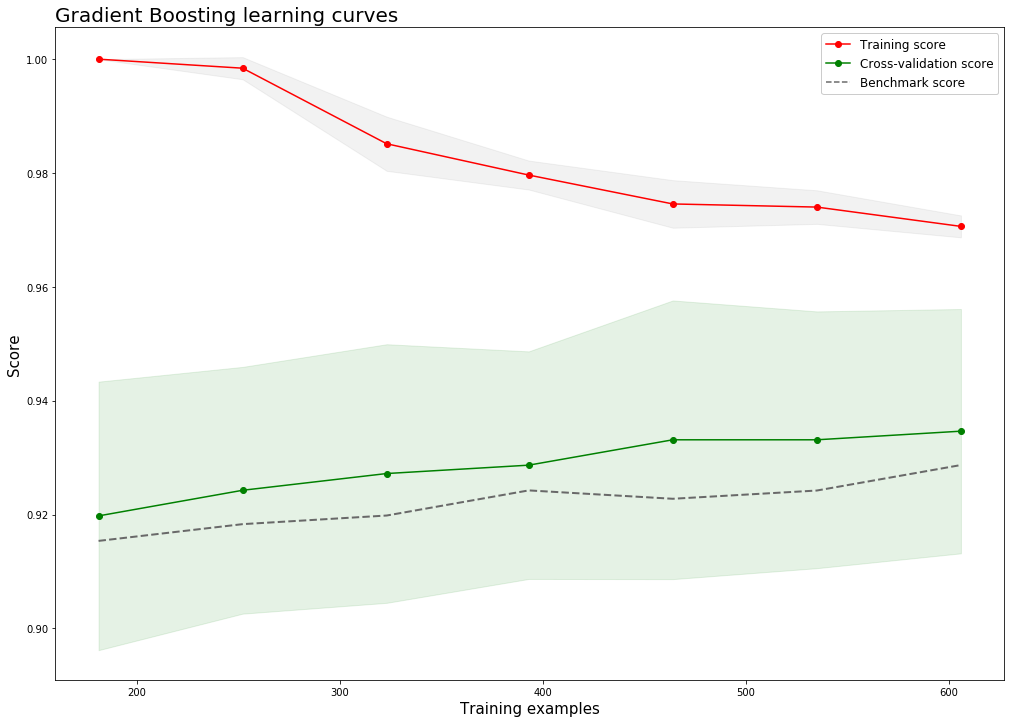

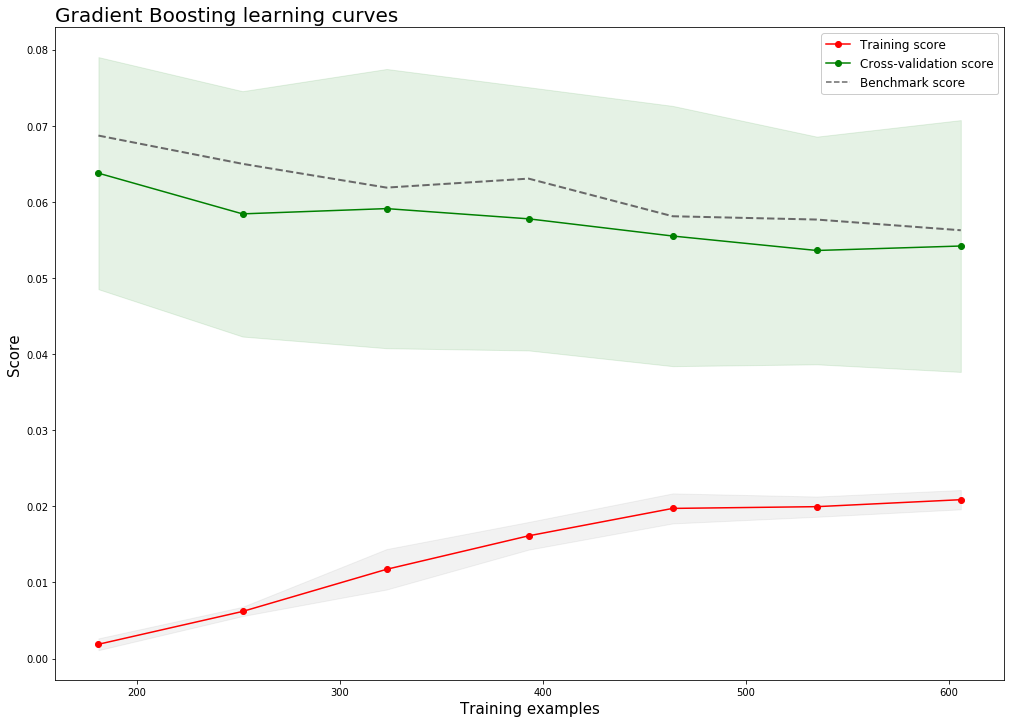

In [262]:
#initiate the model with the tuned parameters
gbc = create_pipeline(GradientBoostingClassifier(**gbc_tuned_params), dummy_mask_rfe)

#train and plot learning curves                      
g, _ = plot_learning_curve(gbc,"Gradient Boosting learning curves",X.loc[:,mask], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = bm_lin_acc)
g, _ = plot_learning_curve(gbc,"Gradient Boosting learning curves",X.loc[:,mask], y,cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = bm_lin_brier,
                       scoring = scorer)

We get a slight improvement over the baseline linear model.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from matplotlib.lines import Line2D


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), benchmark=None,
                       scoring=None):
    """
    Adapted from here:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    _, axes = plt.subplots(1, 1, figsize=(17, 12))
    axes.set_title(title, loc='left', size=20)
    if ylim is not None:
        axes.set_ylim(*ylim)

    axes.set_xlabel("Training examples", size=15)
    axes.set_ylabel("Score", size=15)

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if benchmark is not None:
        plt.plot(train_sizes[:], np.zeros(len(train_sizes))+benchmark, ls="--",
                 color = "dimgrey", lw=2)
    # Plot learning curve
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="grey")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="green")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    lg = axes.legend(loc="upper right", framealpha=1, fontsize='large')
    
    ax = lg.axes
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Line2D([0], [0], color='dimgrey', ls='--'))
    labels.append("Benchmark score")
    
    lg._legend_box = None
    lg._init_legend_box(handles, labels)
    lg._set_loc(lg._loc)
    lg.set_title(lg.get_title().get_text())
    return plt, test_scores_mean